# Melodic Expectation with Recurrent Neural Networks

In this notebook we will explore how to compute musical expectation with Recurrent Neural Networks (RNNs).

RNNs are a family of neural networks designed to model sequential data (like music!).

## Melodic Expectation

We can model musical expectation as a supervised learning problem, by training a model to predict the next event in the sequence. In particular, we can treat this problem as a *supervised classification problem* in which we present the network with a sequence of inputs encoding pitch and temporal information (e.g., note duration, inter-onset interval, ...), and predicting the next event is equivalent to *classifiying* the next event (i.e., which pitch and duration will the next event have).

More formally, we can define this problem as

$$p(\mathbf{x}_{t} \mid \mathbf{x}_{t - 1}, \mathbf{x}_{t - 2}, \dots) = p(\mathbf{x}_t \mid \mathbf{y}_t)$$

where 

* $\mathbf{x}_t$ is the melodic event (i.e., note and duration) at time step $t$. We will denote $v_{ti}$ the $i$-th possible note at time $t$.
* $p(\mathbf{x}_{t} \mid \mathbf{x}_{t - 1}, \mathbf{x}_{t - 2}, \dots)$ is the probability of event $\mathbf{x}_t$ given the sequence $\mathbf{X}_{1:t-1} = \{\mathbf{x}_1, \dots, \mathbf{x}_{t-1}\}$
* $p(\mathbf{x}_t \mid \mathbf{y}_t)$ is the probability of $\mathbf{x}_t$ parametrized by the $\mathbf{y}_t$, the output of the RNN. We will come back to this part.

In [1]:
import glob
import logging
import os

import numpy as np
import partitura
import torch

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from torch import nn
from torch.utils.data import Dataset, ConcatDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)
# Define seed for random number generator
RNG = np.random.RandomState(42)


## Preparing the data
We can load the data and compute the features

In [2]:
from rnn import load_data

# To filter out short melodies The minimum number of notes that a sequence should have
min_seq_len = 10
sequences = load_data(min_seq_len)

INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.

INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.

INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.0010416666666666667at time: 0.0
INFO:partitura.io.importmidi:change of Tempo to mpq = 500000  and resulting seconds per tick = 0.

For simplicity, we are going to assume that pitch and duration/temporal information are independent, so that modeling melodic expectation can be simplified as

$$p(\mathbf{x}_t \mid \mathbf{y}_t) = p(\text{pitch}_t \mid \mathbf{y}_t) p(\text{duration}_t \mid \mathbf{y}_t)$$

(for simplicity, we are using "duration" as the feature representing temporal information, but we can use IOI, or other features)

Since we have natural "categories" for pitch and duration (i.e., each MIDI note number representing the pitch, and each of the individual "duration" values), we can use a one-hot-encoding for each of these features.

$$\mathbf{x}_t = \left(\begin{array}{c}\mathbf{pitch}_t \\ \mathbf{duration}_t\end{array} \right)$$

where $p_it = 1$ if pitch $i$ is the "active" note at time $t$ and $0$ otherwise (and similar for duration).

In [3]:
# Decide which features to use
# Useful info
field_names = [
    "pitch", 
    "onset_sec", 
    "duration_sec"
]

def get_features(seq):
    # Possible things to try:
    # * Use inter onset interval (IOI) instead of duration
    # * Code rest (and duration) instead of IOI
    feature_names = [
        "pitch",
        "duration_sec"
    ]
    
    # construct features
    x = np.column_stack([seq[fn] for fn in feature_names])
    return x

Data = [get_features(x) for x in sequences]

# MIDIs were generated at 100bpm
dur_encoder = OneHotEncoder().fit(np.hstack([np.round(x[:, 1] * 100 / 60, 3) for x in Data]).reshape(-1, 1))
pitch_encoder = OneHotEncoder().fit(np.hstack([x[:, 0] for x in Data]).reshape(-1, 1))

data_one_hot = []
for x in Data:
    pitch_features = pitch_encoder.transform(x[:, 0].reshape(-1, 1)).toarray()
    duration_features = dur_encoder.transform(np.round(x[:, 1] * 100 / 60 , 3).reshape(-1, 1)).toarray()
    data_one_hot.append(np.column_stack([pitch_features, duration_features]))
    
input_size = data_one_hot[0].shape[1]
pitch_idxs = np.arange(len(pitch_encoder.categories_[0]))
dur_idxs = np.arange(len(pitch_encoder.categories_[0]), len(pitch_encoder.categories_[0]) + len(dur_encoder.categories_[0]))

### Task 1: Prepare Dataset

* Decide how to encode temporal information (use durations, ioi, encode rests?). Hint: You can use the same features as in the Markiv Chain Notebook

In [4]:
# data_one_hot
# define one_hot_encoder for the temporal information

Ideally, we would like our data handling code to be decoupled from the model definition and training. PyTorch provides a convenient way to handle data with the `torch.utils.data.Dataset` and `torch.utils.data.DataLoader` classes.

* `Dataset` stores the samples and their corresponding targets
* `DataLoader` wraps an iterable around the `Dataset` to enable easy access to the samples.

We can create a custom `Dataset` for our musical data. A custom `Dataset` class must implement three functions: `__init__`, `__len__`, and `__getitem__`.

In our case, we would like a dataset for which the inputs would be sequences of length $S$

$$ \mathbf{X} = \{\mathbf{x_i}, \dots, \mathbf{x}_{i + S}\}$$

and their corresponding targets are a one-step shifted version of the inputs, i.e.,

$$ \mathbf{Y} = \{\mathbf{x}_{i+1}, \dots, \mathbf{x}_{i + S + 1}\}$$

We can define such a dataset with the following `PieceDataset` class:

In [5]:
class PieceDataset(Dataset):
    """
    Dataset for sequential predictions.
    In this case, if data is a sequence of datapoints,
    the inputs (x) will be x[t:t+seq_len] and outputs would
    be (y) x[t+1:t+seq_len+1] (i.e., the next events)
    """
    def __init__(self, data, seq_len=min_seq_len):
        self.data = data
        self.seq_len = seq_len
        
    @property
    def piecewise(self):
        return self.seq_len == -1

    def __getitem__(self, i):
        if self.piecewise:
            return self._get_item_piecewise(i)
        else:
            return self._get_item_sequencewise(i)

    def _get_item_piecewise(self, i):
        if i > 0:
            raise IndexError
        x = self.data[:-1]
        y = self.data[1:]
        return x, y

    def _get_item_sequencewise(self, i):
        if i + self.seq_len - 1 > len(self.data):
            raise IndexError
        x = self.data[i:i + self.seq_len]
        y = self.data[i + 1: i + self.seq_len + 1]
        return x, y

    def __len__(self):
        if self.piecewise:
            return 1
        else:
            return max(0, len(self.data) - self.seq_len)

## Defining the Model

We can now define an RNN!

PyTorch provides a very convenient way to create neural networks with the `torch.nn.Module` class. This class allows us to define a custom neural architecture, and define how the information should flow in the forward pass.

A module should implement a  `forward` method to define the forward pass. Additionally, RNNs should implement a method for initializing the hidden recurrent layers.

The following code is a simple recurrent model consisting of

* 1 recurrent layer (can be defined as a vanilla RNN, an LSTM or GRU)
* 1 hidden dense layer to embed the output of the recurrent layer

In this case, the dimension of the inputs are the same as the dimensions of the output, since we want to predict the next step.

In [6]:
class RecurrentModel(nn.Module):
    """
    A Simple Recurrent Model
    """

    def __init__(self,
                 input_size,
                 recurrent_size, hidden_size,
                 dropout=0.0,
                 batch_first=True,
                 dtype=torch.float32,
                 rnn_layer=nn.LSTM,
                 device=None):
        nn.Module.__init__(self)
        self.input_size = input_size
        self.recurrent_size = recurrent_size
        self.hidden_size = hidden_size
        self.output_size = input_size
        self.n_layers = 1
        self.batch_first = batch_first
        self.device = device if device is not None else torch.device('cpu')
        self.to(self.device)
        self.dtype = dtype
        self.rnn = rnn_layer(input_size, 
                             self.recurrent_size,
                             self.n_layers,
                             batch_first=batch_first, 
                             dropout=dropout,
                             bidirectional=False)
        dense_in_features = self.recurrent_size
        self.dense = nn.Linear(in_features=dense_in_features,
                               out_features=self.hidden_size)
        self.output = nn.Linear(in_features=self.hidden_size,
                                out_features=self.output_size)

    def init_hidden(self, batch_size):
        
        if isinstance(self.rnn, nn.LSTM):
            h0 = torch.zeros(self.n_layers, batch_size, self.recurrent_size).to(self.dtype)
            c0 = torch.zeros(self.n_layers, batch_size, self.recurrent_size).to(self.dtype)
            return (h0, c0)
        else:
            return torch.zeros(self.n_layers, batch_size, self.recurrent_size).to(self.dtype)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        h0 = self.init_hidden(batch_size)
        output, h = self.rnn(x, h0)
        flatten_shape = self.recurrent_size
        dense = self.dense(output.contiguous().view(-1, flatten_shape))
        y = self.output(dense)
        y = y.view(batch_size, seq_len, self.output_size)

        return y
    
rnn = RecurrentModel(input_size=input_size, recurrent_size=64, hidden_size=64)

## Training the Model

In order to train the model, we need to specify a loss function.

A common loss function for classification tasks is the Cross Entropy Loss. Since our network is basically predicting (classifiying) a pitch and a duration with different parts of the output vector, we can simply compute the cross entropy of the pitch and the cross entropy of the duration, and add the together


In [7]:
class PitchDurationCrossEntropyLoss(nn.Module):
    """
    Cross Entropy of Pitch and Duration
    """
    def __init__(self, pitch_idxs, dur_idxs, weights=[0.5, 0.5], name='PitchDurationCrossEntropyLoss'):
        nn.Module.__init__(self)
        self.pitch_idxs = pitch_idxs
        self.dur_idxs = dur_idxs    
        self.weights = weights
        self.name = name
        self.ce = nn.CrossEntropyLoss()

    def __call__(self, predictions, targets):
        pitch_preds = predictions[:, :, self.pitch_idxs]
        pitch_preds = pitch_preds.view(-1, pitch_preds.size(2))
        dur_preds = predictions[:, :, self.dur_idxs]
        dur_preds = dur_preds.view(-1, dur_preds.size(2))
        pitch_target = targets[:, :, self.pitch_idxs].argmax(-1).view(-1).to(torch.long)
        dur_target = targets[:, :, self.dur_idxs].argmax(-1).view(-1).to(torch.long)
        loss = (self.weights[0] * self.ce(pitch_preds, pitch_target) + 
                self.weights[1] * self.ce(dur_preds, dur_target))
        return loss


We now split the data into training, validation and test sets

In [8]:
# The dataset will be the concatenation of the datasets for each piece
dataset = ConcatDataset([PieceDataset(piece, seq_len=-1) for piece in data_one_hot])

# Select training, test and validation sets
dataset_idx = np.arange(len(dataset))

valid_size = 0.2
test_size = 0.3
batch_size = 1

trainvalid_idx, test_idx = train_test_split(dataset_idx, 
                                            test_size=0.33,
                                            random_state=RNG)

RNG.shuffle(trainvalid_idx)
len_valid = int(np.round(len(dataset) * valid_size))
valid_idx = dataset_idx[0:len_valid]
train_idx = dataset_idx[len_valid:]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
test_sampler = SubsetRandomSampler(test_idx)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

We can now setup the training of the model!

The `SupervisedTrainer` class is a helper to setup a function to train a model in a supervised way.

**Try changing a couple settings**

* Adjusting learning rate
* Selecting an Optimizer (see [torch.optim](https://pytorch.org/docs/stable/optim.html?highlight=optimization))

In [15]:
from rnn import SupervisedTrainer

train_loss = PitchDurationCrossEntropyLoss(pitch_idxs, dur_idxs, name="Train")
valid_loss = PitchDurationCrossEntropyLoss(pitch_idxs, dur_idxs, name="Validation")
learning_rate = 0.01
epochs = 10
early_stopping = 2

optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

trainer = SupervisedTrainer(model=rnn,
                            train_loss=train_loss,
                            valid_loss=valid_loss,
                            train_dataloader=train_loader,
                            valid_dataloader=valid_loader,
                            epochs=epochs,
                            save_freq=1, # This parameter controlls how often the model is validated
                            early_stopping=early_stopping,
                            optimizer=optimizer)

Now we are ready to train the model!

In [10]:
trainer.train()

INFO:rnn:Saving current best: ./best_model.pth ...
epoch: 1/10 loss: 3.79: 100%|██████████| 137/137 [00:06<00:00, 19.63it/s]
INFO:rnn:Epoch:0	Train 3.955	Validation 3.838
INFO:rnn:Saving checkpoint: ./checkpoint-epoch-0.pth ...
INFO:rnn:Saving current best: ./best_model.pth ...
epoch: 2/10 loss: 3.57: 100%|██████████| 137/137 [00:06<00:00, 19.95it/s]
INFO:rnn:Epoch:1	Train 3.741	Validation 3.564
INFO:rnn:Saving checkpoint: ./checkpoint-epoch-1.pth ...
INFO:rnn:Saving current best: ./best_model.pth ...
epoch: 3/10 loss: 3.25: 100%|██████████| 137/137 [00:06<00:00, 19.75it/s]
INFO:rnn:Epoch:2	Train 3.425	Validation 3.165
INFO:rnn:Saving checkpoint: ./checkpoint-epoch-2.pth ...
INFO:rnn:Saving current best: ./best_model.pth ...
epoch: 4/10 loss: 3.69: 100%|██████████| 137/137 [00:06<00:00, 19.61it/s]
INFO:rnn:Epoch:3	Train 3.072	Validation 2.883
INFO:rnn:Saving checkpoint: ./checkpoint-epoch-3.pth ...
INFO:rnn:Saving current best: ./best_model.pth ...
epoch: 5/10 loss: 2.69: 100%|████████

It is useful to have a look at the training curves. Since ANNs are prone to overfitting, comparing the behavior of the training loss and the validation loss can be very useful.

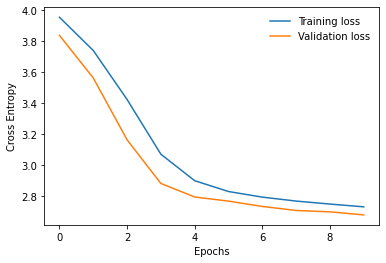

In [14]:
train_loss_fn = os.path.join(".", "train_loss.txt")
train_loss_curve = np.loadtxt(train_loss_fn)
valid_loss_fn = os.path.join(".", "valid_loss.txt")
valid_loss_curve = np.loadtxt(valid_loss_fn)
plt.plot(train_loss_curve[:, 0], train_loss_curve[:, 1], label="Training loss")
plt.plot(valid_loss_curve[:, 0], valid_loss_curve[:, 1], label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Cross Entropy")
plt.legend(frameon=False)

In [16]:
def eval_model(model, test_loader, loss=valid_loss):
    test_ce = []
    model.eval()
    for i, (x, y) in enumerate(test_loader):
        preds = model(x.to(model.dtype))
        ce = loss(preds, y)
        test_ce.append(ce.item())
        
    return np.mean(test_ce)

**Task 2**

Define and train 2 different models. You can decide on the architecture and the optimization.

Compare the performance of both models

In [18]:
# Cross entropy of the trained model on the test set
eval_model(rnn, test_loader, loss=valid_loss)

2.7263971420756556

In [ ]:
### Task 3

Compute the probability of an event musical sequences. How would you compute how probable is an event

You can select one of the sequences in the test set, or define your own melody and see how probable is the sequence